# 第5章 ノード埋め込み


## 5.4.2 データセットのダウンロードと前処理

In [ ]:
# 依存ライブラリのインストール
!pip uninstall -y fastai torch torchaudio torchvision
!pip install torch==2.0.0+cpu \
 --index-url https://download.pytorch.org/whl/cpu
!pip install torch-cluster torch-scatter torch-sparse \
 -f https://data.pyg.org/whl/torch-2.0.0+cpu.html

Found existing installation: torch 2.0.0+cpu
Uninstalling torch-2.0.0+cpu:
  Successfully uninstalled torch-2.0.0+cpu
Looking in indexes: https://download.pytorch.org/whl/cpu
  Using cached https://download.pytorch.org/whl/cpu/torch-2.0.0%2Bcpu-cp311-cp311-linux_x86_64.whl (195.4 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
timm 1.0.14 requires torchvision, which is not installed.
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html


In [ ]:
# 必要なライブラリのインストール
!pip install torch-geometric==2.3.1

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.datasets import Planetoid

# torch_geometric の Dataset としてダウンロード
dataset = Planetoid(root="./dataset", name="Cora", split="full")

Processing...
Done!


In [ ]:
# Planetoid は torch_geometric の InMemoryDataset を継承している
# そのため、torch_geometric での学習が容易である
print(f"データセットの型 : {type(dataset)}")
print(f"ネットワークの型 : {type(dataset._data)}")

データセットの型 : <class 'torch_geometric.datasets.planetoid.Planetoid'>
ネットワークの型 : <class 'torch_geometric.data.data.Data'>


In [ ]:
from collections import Counter
from torch_geometric.utils.convert import to_networkx

# PyTorch Geometric -> NetworkX への変換
cora_network = to_networkx(dataset._data, node_attrs=["y"])
print(f"ネットワークの型 : {type(cora_network)}")
print(f"ノード数 : {cora_network.number_of_nodes():,}")
print(f"エッジ数 : {cora_network.number_of_edges():,}")

ネットワークの型 : <class 'networkx.classes.digraph.DiGraph'>
ノード数 : 2,708
エッジ数 : 10,556


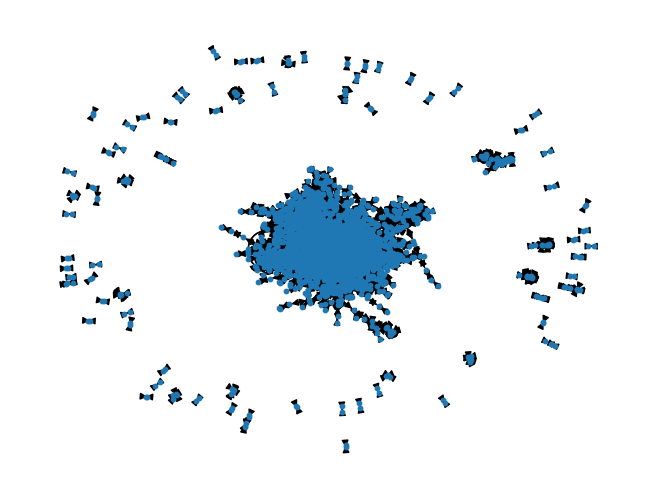

In [ ]:
# Coraネットワークの描画
nx.draw(cora_network, node_size=10)

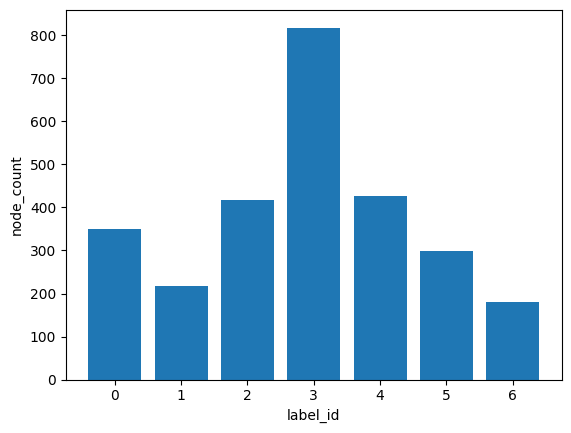

In [ ]:
# 各論文の技術領域に対応するIDを取得
labels = nx.get_node_attributes(cora_network, "y")
label_counter = Counter(labels.values())

# ラベル分布を表示
plt.bar(
    [k for k, _ in sorted(label_counter.items())],
    [v for _, v in sorted(label_counter.items())],
)
plt.xlabel("label_id")
plt.ylabel("node_count")
plt.show()

In [ ]:
from torch_geometric.transforms import RandomNodeSplit

# ノードを学習データとテストデータに分割
node_splitter = RandomNodeSplit(
    split="train_rest",
    num_splits=1,
    num_val=0.0,
    num_test=0.4,
    key="y",
)
splitted_data = node_splitter(dataset._data)
print(splitted_data.node_attrs())
print(splitted_data.train_mask)
print(splitted_data.test_mask)

['val_mask', 'train_mask', 'x', 'y', 'test_mask']
tensor([ True, False, False,  ..., False, False, False])
tensor([False,  True,  True,  ...,  True,  True,  True])


## 5.4.3 node2vecによる分散表現の学習

In [ ]:
import torch
from torch_geometric.nn import Node2Vec

# node2vecモデルの定義
device = "cuda" if torch.cuda.is_available() else "cpu"
n2v_model = Node2Vec(
    splitted_data.edge_index,
    embedding_dim=64,
    walk_length=5,
    context_size=5,
    walks_per_node=10,
    num_negative_samples=1,
    p=1,
    q=1,
    sparse=False,
).to(device)

# 最適化アルゴリズムの選択
n2v_optimizer = torch.optim.Adam(
    list(n2v_model.parameters()),
    lr=0.01,
)

In [ ]:
from tqdm import tqdm


# node2vec の学習を行う関数の定義
def train_n2v() -> float:
    n2v_model.train()
    total_loss = 0.0

    loader = n2v_model.loader(batch_size=8, shuffle=True)

    # サンプリングしたランダムウォークの読み込み
    for pos_rw, neg_rw in tqdm(loader):
        n2v_optimizer.zero_grad()

        # 損失の計算
        loss = n2v_model.loss(
            pos_rw.to(device),
            neg_rw.to(device),
        )
        loss.backward()
        n2v_optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


# 学習の実行
for epoch in range(30):
    loss = train_n2v()
    print(f"train loss : {loss:.4f}")

100%|██████████| 339/339 [00:00<00:00, 393.98it/s]


train loss : 5.5564


100%|██████████| 339/339 [00:00<00:00, 377.39it/s]


train loss : 3.6989


100%|██████████| 339/339 [00:00<00:00, 377.19it/s]


train loss : 2.8999


100%|██████████| 339/339 [00:00<00:00, 386.62it/s]


train loss : 2.3969


100%|██████████| 339/339 [00:00<00:00, 385.04it/s]


train loss : 2.0266


100%|██████████| 339/339 [00:00<00:00, 375.25it/s]


train loss : 1.7516


100%|██████████| 339/339 [00:01<00:00, 270.07it/s]


train loss : 1.5184


100%|██████████| 339/339 [00:01<00:00, 264.06it/s]


train loss : 1.3519


100%|██████████| 339/339 [00:00<00:00, 383.92it/s]


train loss : 1.2124


100%|██████████| 339/339 [00:00<00:00, 377.00it/s]


train loss : 1.1136


100%|██████████| 339/339 [00:00<00:00, 384.22it/s]


train loss : 1.0391


100%|██████████| 339/339 [00:00<00:00, 388.68it/s]


train loss : 0.9808


100%|██████████| 339/339 [00:00<00:00, 398.77it/s]


train loss : 0.9435


100%|██████████| 339/339 [00:00<00:00, 384.41it/s]


train loss : 0.9173


100%|██████████| 339/339 [00:00<00:00, 387.86it/s]


train loss : 0.9015


100%|██████████| 339/339 [00:00<00:00, 380.88it/s]


train loss : 0.8879


100%|██████████| 339/339 [00:00<00:00, 392.71it/s]


train loss : 0.8774


100%|██████████| 339/339 [00:00<00:00, 391.12it/s]


train loss : 0.8734


100%|██████████| 339/339 [00:00<00:00, 381.02it/s]


train loss : 0.8709


100%|██████████| 339/339 [00:01<00:00, 286.64it/s]


train loss : 0.8691


100%|██████████| 339/339 [00:01<00:00, 259.33it/s]


train loss : 0.8700


100%|██████████| 339/339 [00:00<00:00, 358.43it/s]


train loss : 0.8721


100%|██████████| 339/339 [00:00<00:00, 390.90it/s]


train loss : 0.8750


100%|██████████| 339/339 [00:00<00:00, 393.94it/s]


train loss : 0.8772


100%|██████████| 339/339 [00:00<00:00, 389.96it/s]


train loss : 0.8746


100%|██████████| 339/339 [00:00<00:00, 347.09it/s]


train loss : 0.8736


100%|██████████| 339/339 [00:01<00:00, 249.27it/s]


train loss : 0.8761


100%|██████████| 339/339 [00:01<00:00, 293.43it/s]


train loss : 0.8788


100%|██████████| 339/339 [00:01<00:00, 295.47it/s]


train loss : 0.8791


100%|██████████| 339/339 [00:01<00:00, 254.02it/s]

train loss : 0.8760


## 5.4.4 ロジスティック回帰による論文の技術領域の分類

In [ ]:
# ノードに対応するベクトルを行列形式で獲得
embedding_matrix = n2v_model.embedding(
    torch.arange(splitted_data.num_nodes)
)
print(embedding_matrix.shape)

torch.Size([2708, 64])


In [ ]:
# あらかじめ与えられた特徴量へのアクセス
print(splitted_data.x.shape)

torch.Size([2708, 1433])


In [ ]:
# あらかじめ与えられた特徴量を用いたロジスティック回帰モデルの学習
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

baseline_classifier = LogisticRegression(
    max_iter=1000,
    random_state=0,
)
X_train = splitted_data.x[splitted_data.train_mask].numpy()
y_train = splitted_data.y[splitted_data.train_mask].numpy()
baseline_classifier.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=0)

In [ ]:
# 評価データに対する推論
X_test = splitted_data.x[splitted_data.test_mask].numpy()
y_true = splitted_data.y[splitted_data.test_mask].numpy()
y_pred = baseline_classifier.predict(X_test)

# 評価結果の表示
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.64      0.63       137
           1       0.79      0.68      0.73        84
           2       0.85      0.83      0.84       184
           3       0.74      0.83      0.78       314
           4       0.76      0.80      0.78       166
           5       0.73      0.56      0.63       128
           6       0.67      0.61      0.64        70

    accuracy                           0.74      1083
   macro avg       0.74      0.71      0.72      1083
weighted avg       0.75      0.74      0.74      1083



In [ ]:
# ノードの分散表現を特徴量に加えたロジスティック回帰モデルの学習
n2v_classifier = LogisticRegression(
    max_iter=1000,
    random_state=0,
)
X_train = torch.cat(
    (
        splitted_data.x[splitted_data.train_mask],
        embedding_matrix[splitted_data.train_mask],
    ),
    dim=1,
).detach().numpy()
y_train = splitted_data.y[splitted_data.train_mask].numpy()
n2v_classifier.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=0)

In [ ]:
# テストデータに対する推論
X_test = torch.cat(
    (
        splitted_data.x[splitted_data.test_mask],
        embedding_matrix[splitted_data.test_mask],
    ),
    dim=1,
).detach().numpy()
y_true = splitted_data.y[splitted_data.test_mask].numpy()
y_pred = n2v_classifier.predict(X_test)

# 評価結果の表示
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.73      0.74       137
           1       0.81      0.70      0.75        84
           2       0.90      0.89      0.90       184
           3       0.81      0.88      0.84       314
           4       0.81      0.84      0.82       166
           5       0.84      0.70      0.76       128
           6       0.67      0.73      0.70        70

    accuracy                           0.81      1083
   macro avg       0.80      0.78      0.79      1083
weighted avg       0.81      0.81      0.81      1083

